## FLOOD PREDICTION


In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:

# Load dataset
df = pd.read_csv(r'flood_risk_dataset_india.csv')
df.head()
# Separate features and target
X = df.drop('Flood Occurred', axis=1)
y = df['Flood Occurred']

# Categorical and numerical columns
categorical_cols = ['Land Cover', 'Soil Type']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# # Target encoding
# def target_encode(df, cols, target, n_splits=5):
#     df_encoded = df.copy()
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     for col in cols:
#         encoded_col = np.zeros(df.shape[0])
#         for train_idx, test_idx in kf.split(df):
#             train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]
#             means = train_data.groupby(col)[target].mean()
#             encoded_col[test_idx] = test_data[col].map(means)
#         df_encoded[col] = encoded_col
#     return df_encoded

def target_encode(df, cols, target, n_splits=5):
    df_encoded = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for col in cols:
        encoded_col = np.zeros(df.shape[0])  # Placeholder for encoded values
        
        for train_idx, test_idx in kf.split(df):
            train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]
            
            if target not in train_data.columns:  # Ensure target column exists
                raise ValueError(f"'{target}' column missing in train_data. Check input!")

            means = train_data.groupby(col)[target].mean()  # Compute mean encoding
            encoded_col[test_idx] = test_data[col].map(means)

        df_encoded[col] = encoded_col  # Replace categorical with encoded values
    
    return df_encoded


# Apply target encoding
X_encoded = target_encode(df, categorical_cols, 'Flood Occurred')


# for null values

assert not X_encoded.isnull().values.any(), "Missing values found after encoding!"

# Numerical preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Only transform numerical features (categoricals already encoded)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
    ],
    remainder='passthrough'  # keep target-encoded categorical columns
)

# Apply transformations
X_preprocessed = preprocessor.fit_transform(X_encoded)

# Combine numerical & target-encoded categorical features
processed_feature_names = numerical_cols + categorical_cols  # Ensure correct feature names

processed_feature_names = preprocessor.get_feature_names_out()


# Convert to DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=processed_feature_names)



print("Processed Data Shape:", X_preprocessed.shape)
print("Feature Name Count:", len(processed_feature_names))
print(X_preprocessed_df.head())






Processed Data Shape: (10000, 14)
Feature Name Count: 14
   num__Latitude  num__Longitude  num__Rainfall (mm)  num__Temperature (°C)  \
0      -0.415900       -0.452465            0.801884               0.482494   
1       1.587377       -0.593258           -1.100359              -0.136414   
2       0.826917       -1.135149           -0.534981               1.611824   
3       0.363328        0.355146            0.569224              -0.968007   
4      -1.175669       -0.096466           -0.062635               0.308475   

   num__Humidity (%)  num__River Discharge (m³/s)  num__Water Level (m)  \
0          -0.684316                     1.193409              0.833556   
1          -1.389866                    -0.029923              1.318694   
2          -1.280827                    -1.067119             -0.134223   
3          -1.093072                     0.809835             -0.739142   
4          -1.013623                    -0.292954             -0.636001   

   num__Elevation

In [3]:
xgb_model = XGBClassifier(
    n_estimators=50, learning_rate=0.05, max_depth=3, 
    min_child_weight=8, gamma=0.4, eval_metric='logloss', random_state=42
)

rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, 
                                  min_samples_split=8, random_state=42)




# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.2, random_state=42, stratify=y)

# 2. Define models

xgb_model = XGBClassifier(
    n_estimators=50, learning_rate=0.05, max_depth=3, 
    min_child_weight=8, gamma=0.4, eval_metric='logloss', random_state=42
)

rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, 
                                  min_samples_split=8, random_state=42)

# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4,  eval_metric='logloss')   # use_label_encoder=False,

# 3. Create soft voting ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  # soft voting considers predicted probabilities
)

# 4. Train the ensemble
ensemble_model.fit(X_train, y_train)

# 5. Evaluate
y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Expected Feature Count:", len(processed_feature_names))
# 6. Print results
print("✅ Ensemble Model Accuracy:", accuracy)
print("\n🧾 Classification Report:\n", report)
print("\n🔲 Confusion Matrix:\n", conf_matrix)

Expected Feature Count: 14
✅ Ensemble Model Accuracy: 1.0

🧾 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       989
           1       1.00      1.00      1.00      1011

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


🔲 Confusion Matrix:
 [[ 989    0]
 [   0 1011]]


## Feature importance

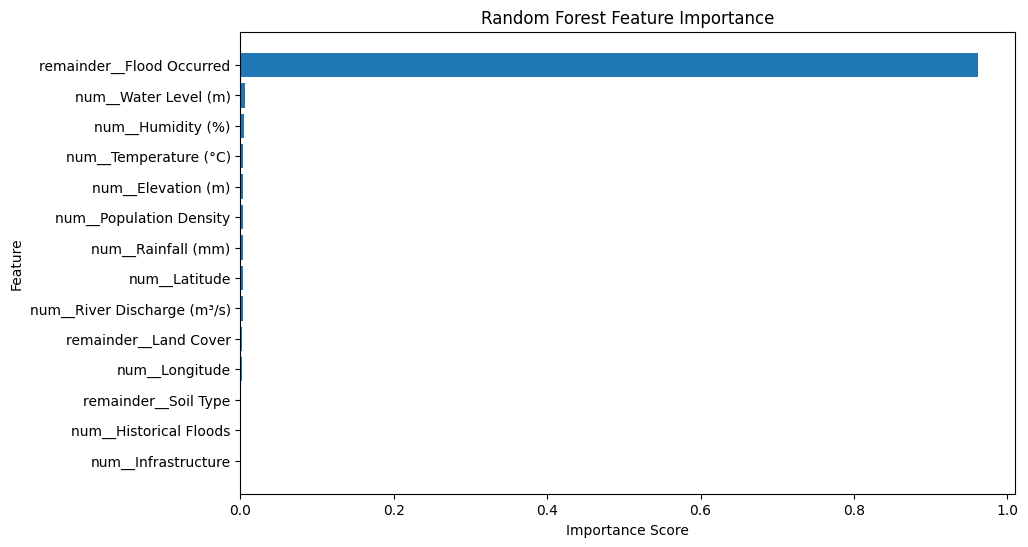

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


rf_model.fit(X_train, y_train)  # Train Random Forest

# Extract feature importance
rf_importance = rf_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame for visualization
rf_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importance})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


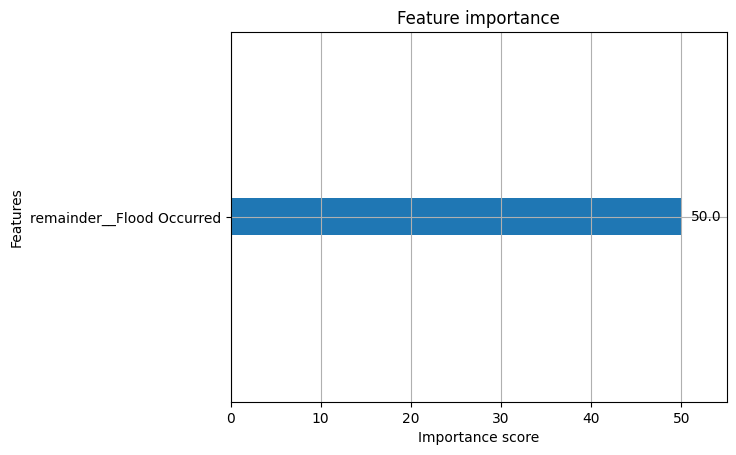

In [5]:
from xgboost import plot_importance

xgb_model.fit(X_train,y_train)

# Plot XGBoost feature importance
plot_importance(xgb_model)
plt.show()


In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=cv, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Average CV Accuracy:", cv_scores.mean())


Cross-Validation Accuracy Scores: [1. 1. 1. 1. 1.]
Average CV Accuracy: 1.0


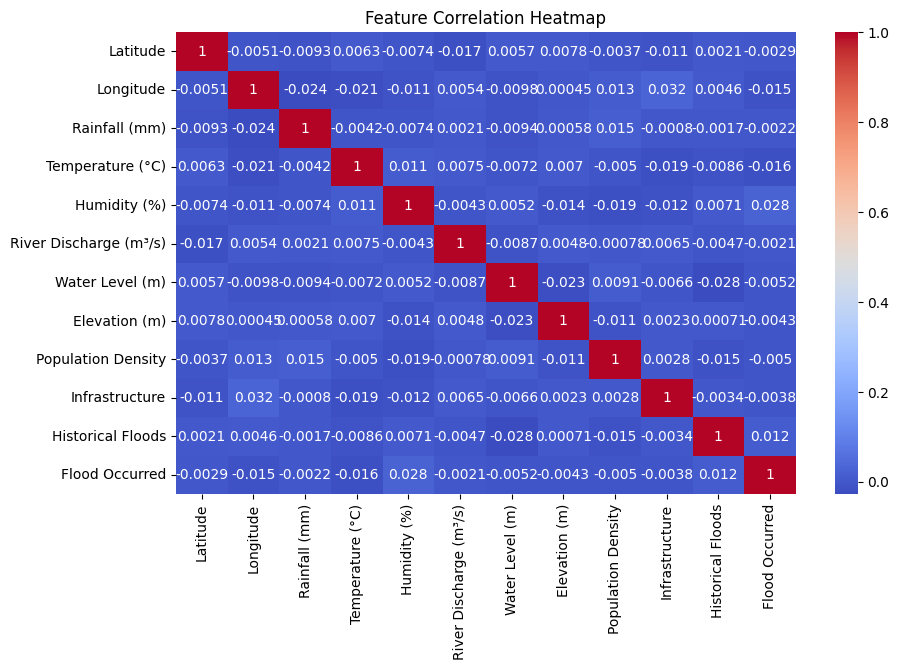

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical features
df_numeric = df.select_dtypes(include=['number'])  # Filters out non-numeric columns

# Plot correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [8]:
from sklearn.metrics import roc_auc_score, log_loss

y_prob = ensemble_model.predict_proba(X_test)[:,1]
print("AUC-ROC:", roc_auc_score(y_test, y_prob))
print("Log-Loss:", log_loss(y_test, y_prob))


AUC-ROC: 1.0
Log-Loss: 0.0762642548985667


In [9]:
# save rhe model
import joblib

# Save model and preprocessor
joblib.dump(ensemble_model, 'ensemble_flood_model.pkl')
joblib.dump(preprocessor, 'flood_preprocessor.pkl')


['flood_preprocessor.pkl']

##  later when you want to use it

In [11]:
df.head()

,Latitude,Longitude,Rainfall (mm),Temperature (°C),Humidity (%),River Discharge (m³/s),Water Level (m),Elevation (m),Land Cover,Soil Type,Population Density,Infrastructure,Historical Floods,Flood Occurred
0,18.861663,78.835584,218.999493,34.144337,43.912963,4236.182888,7.415552,377.465433,Water Body,Clay,7276.742184,1,0,1
1,35.570715,77.654451,55.353599,28.778774,27.585422,2472.585219,8.811019,7330.608875,Forest,Peat,6897.736956,0,1,0
2,29.227824,73.108463,103.991908,43.934956,30.108738,977.328053,4.631799,2205.873488,Agricultural,Loam,4361.518494,1,1,1
3,25.361096,85.610733,198.984191,21.569354,34.453690,3683.208933,2.891787,2512.277800,Desert,Sandy,6163.069701,1,1,0
4,12.524541,81.822101,144.626803,32.635692,36.292267,2093.390678,3.188466,2001.818223,Agricultural,Loam,6167.964591,1,0,0


In [32]:
import pandas as pd
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Example input data with exact column names
dat = pd.DataFrame({
    'Latitude': [150.5],                    # Latitude
    'Longitude': [32.5],                    # Longitude
    'Rainfall (mm)': [80],                  # Rainfall (mm)
    'Temperature (°C)': [32.5],             # Temperature (°C)
    'Humidity (%)': [75],                   # Humidity (%)
    'River Discharge (m³/s)': [1000],       # River Discharge (m³/s)
    'Water Level (m)': [5.0],               # Water Level (m)
    'Elevation (m)': [300],                 # Elevation (m)
    'Land Cover': [1],           # Land Cover (e.g., 'Water Body')
    'Soil Type': [1],                  # Soil Type (e.g., 'Clay')
    'Population Density': [5000],           # Population Density
    'Infrastructure': [1],              # Infrastructure (e.g., 'Low')
    'Historical Floods': [1],           # Historical Floods (e.g., 'Yes')
    'Flood Occurred': [0]                   # Flood Occurred (Target)
})

# Load model and preprocessor
ensemble_model = joblib.load('ensemble_flood_model.pkl')
preprocessor = joblib.load('flood_preprocessor.pkl')

# Print the columns the preprocessor expects
print("Columns expected by preprocessor:", preprocessor.get_feature_names_out())

# Define categorical and numerical columns (no target column here for preprocessing)
categorical_columns = ['Land Cover', 'Soil Type', 'Infrastructure', 'Historical Floods']
numerical_columns = ['Latitude', 'Longitude', 'Rainfall (mm)', 'Temperature (°C)', 
                     'Humidity (%)', 'River Discharge (m³/s)', 'Water Level (m)', 
                     'Elevation (m)', 'Population Density']

# Ensure 'Flood Occurred' is treated as a feature during preprocessing
dat_with_flood = dat.copy()  # Make a copy to preserve original data

# Preprocessing the new input using the loaded preprocessor (this ensures the sample is treated the same as training data)
X_new_transformed = preprocessor.transform(dat_with_flood)

# Re-adding the 'Flood Occurred' column after transformation
dat_transformed = pd.DataFrame(X_new_transformed, columns=preprocessor.get_feature_names_out())
dat_transformed['Flood Occurred'] = dat['Flood Occurred'].values

# Check the shape of the transformed data (ensure it matches the training data's feature count)
print("Shape of transformed input data:", dat_transformed.shape)

# Predict using the ensemble model
y_pred = ensemble_model.predict(X_new_transformed)

# Output the prediction result
print("Prediction (Flood Occurred):", y_pred)

# Optionally, check the actual 'Flood Occurred' column for comparison
actual_flood_occurrence = dat['Flood Occurred'].iloc[0]
print("Actual Flood Occurred (for comparison):", actual_flood_occurrence)


Columns expected by preprocessor: ['num__Latitude' 'num__Longitude' 'num__Rainfall (mm)'
 'num__Temperature (°C)' 'num__Humidity (%)' 'num__River Discharge (m³/s)'
 'num__Water Level (m)' 'num__Elevation (m)' 'num__Population Density'
 'num__Infrastructure' 'num__Historical Floods' 'remainder__Land Cover'
 'remainder__Soil Type' 'remainder__Flood Occurred']
Shape of transformed input data: (1, 15)
Prediction (Flood Occurred): [0]
Actual Flood Occurred (for comparison): 0


C:\Users\londh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
